In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import scikeras
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('data_model.csv', index_col = 0)
df.sample(5)

,T1,F1,F2,F3,F4,F5,F6,T2,T3,F7,F9,F10
154.0,2.015363,2028.596291,634.827025,115.034794,23.703777,293.849227,245.590610,80.254453,1486.094794,185.830078,5.167349,47.264761
920.0,1.304715,2033.835477,308.357686,58.242933,22.118429,250.897046,352.690479,71.860363,2823.012189,299.111907,8.586120,57.315247
20.0,2.877358,2000.000000,205.000000,111.860000,22.267857,284.615385,1010.000000,78.000000,2000.000000,300.000000,4.000000,47.000000
590.0,3.487507,2023.287396,1276.816013,106.901561,23.954549,232.522725,237.953725,76.149068,1859.029188,201.588044,7.765051,60.985894
610.0,3.311244,2076.665686,1089.484745,57.005741,18.847271,298.230819,198.270408,77.242913,2931.632323,275.915787,6.027006,76.381451


In [3]:
#df_1 = df.drop(['F1', 'F4', 'F5', 'F6', 'T2', 'F7', 'F8', 'F10'], axis = 1)

In [4]:
ds = df.values
X = ds[:,1:12]
y = ds[:,0]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state = 42)

#res= clf._predict_proba_lr(X_test,Y_test)

X_train.shape

(655, 11)

2. Разрабатываем базовую модель

Строим простую полносвязную нейронную сеть (feed forward neural network). Выходной слой с одним линейным нейроном — для задачи регрессии. Функция активации — RELU в промежуточном слое и отсутствует в выходном.

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Activation, Dropout, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [8]:
X_train_norm = normalizer.adapt(np.array(X_train))

In [9]:
X_train.shape

(655, 11)

In [10]:
model = Sequential([
    Dense(12, activation='relu', kernel_initializer='normal', input_dim = 11),
    Dense(12, activation='relu', kernel_initializer='normal'),
    Dense(6, activation='relu', kernel_initializer='normal'),
    Dense(1, kernel_initializer='normal'),
])

model.compile(optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                144       
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 6)                 78        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [12]:
%%time
history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=50,
    verbose=1,
    validation_split = 0.2
    )

Epoch 1/50
9/9 [==============================] - 1s 34ms/step - loss: 8.7075 - mae: 2.8047 - val_loss: 7.3170 - val_mae: 2.5588
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 6.3768 - mae: 2.3482 - val_loss: 4.4757 - val_mae: 1.9273
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 3.1200 - mae: 1.5218 - val_loss: 1.2197 - val_mae: 0.8792
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 1.0324 - mae: 0.8130 - val_loss: 1.3420 - val_mae: 0.9392
Epoch 5/50
9/9 [==============================] - 0s 6ms/step - loss: 1.1602 - mae: 0.8704 - val_loss: 0.8568 - val_mae: 0.7361
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 0.9127 - mae: 0.7749 - val_loss: 0.9055 - val_mae: 0.7508
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 0.9214 - mae: 0.7720 - val_loss: 0.8369 - val_mae: 0.7249
Epoch 8/50
9/9 [==============================] - 0s 6ms/step - loss: 0.8846 - mae: 0.7647 - val_loss: 

In [13]:
mse, mae = model.evaluate(X_test, y_test, verbose=0)

In [14]:
print("Средняя абсолютная ошибка (ед.):", mae)

Средняя абсолютная ошибка (ед.): 0.7020210027694702


In [15]:
pred = model.predict(X_test)
print("Предсказанное соотношение:", pred[1][0], ", правильное соотношение:", y_test[1])

Предсказанное соотношение: 3.0132468 , правильное соотношение: 1.94002141130966


In [16]:
# Предсказание vs правильный ответ
for i in range(len(pred)):
  print("Сеть сказала: ", np.round(pred[i],2), ", а верный ответ: ", np.round(y_test[i],2), ", разница: ", np.round(pred[i] - y_test[i],2))

Сеть сказала:  [2.81] , а верный ответ:  2.87 , разница:  [-0.06]
Сеть сказала:  [3.01] , а верный ответ:  1.94 , разница:  [1.07]
Сеть сказала:  [3.17] , а верный ответ:  1.72 , разница:  [1.45]
Сеть сказала:  [2.93] , а верный ответ:  4.6 , разница:  [-1.67]
Сеть сказала:  [2.82] , а верный ответ:  3.46 , разница:  [-0.64]
Сеть сказала:  [2.91] , а верный ответ:  2.68 , разница:  [0.23]
Сеть сказала:  [2.81] , а верный ответ:  1.52 , разница:  [1.28]
Сеть сказала:  [2.94] , а верный ответ:  3.55 , разница:  [-0.61]
Сеть сказала:  [2.77] , а верный ответ:  2.57 , разница:  [0.19]
Сеть сказала:  [2.95] , а верный ответ:  2.38 , разница:  [0.57]
Сеть сказала:  [3.02] , а верный ответ:  2.05 , разница:  [0.98]
Сеть сказала:  [2.95] , а верный ответ:  2.45 , разница:  [0.5]
Сеть сказала:  [3.] , а верный ответ:  3.41 , разница:  [-0.41]
Сеть сказала:  [2.95] , а верный ответ:  2.51 , разница:  [0.44]
Сеть сказала:  [2.8] , а верный ответ:  3.48 , разница:  [-0.68]
Сеть сказала:  [2.81] , 

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
#Функция для построения графика потерь модели на тренировочной и тестовой выборках
def model_loss_plot(model_history):
    plt.figure(figsize=(10, 5))
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('График потерь модели', size=12)
    plt.ylabel('Средняя абсолютная ошибка', size=12)
    plt.xlabel('Эпоха', size=12)
    plt.legend(['loss', 'val_loss'], loc='best')
    plt.show()

In [19]:
#Функция для построения графика оригинального и предсказанного значения у
def actual_and_predicted_plot(original_y, predicted_y):    
    plt.figure(figsize=(15,5))
    plt.title('Тестовые и прогнозные значения', size=12)
    plt.plot(original_y, color='blue', label = 'Тестовые значения')
    plt.plot(predicted_y, color='red', label = 'Прогнозные значения')
    plt.legend(loc='best')
    plt.show()

In [20]:
#Функция для построения точечного графика оригинального и предсказанного значения у   
def actual_and_predicted_scatter(original_y, predicted_y):
    plt.figure(figsize=(10,5))
    plt.title('Рассеяние тестовых и прогнозных значений', size=15)
    plt.scatter(original_upr, predicted_upr)
    plt.xlabel('Тестовые значения', size=12)
    plt.ylabel('Прогнозные значения', size=12)
    plt.legend(loc='best')
    plt.show()

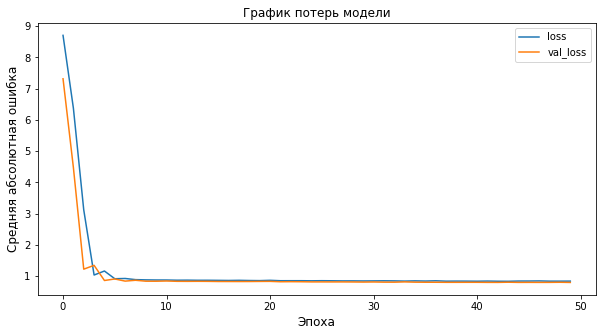

In [21]:
model_loss_plot(history)

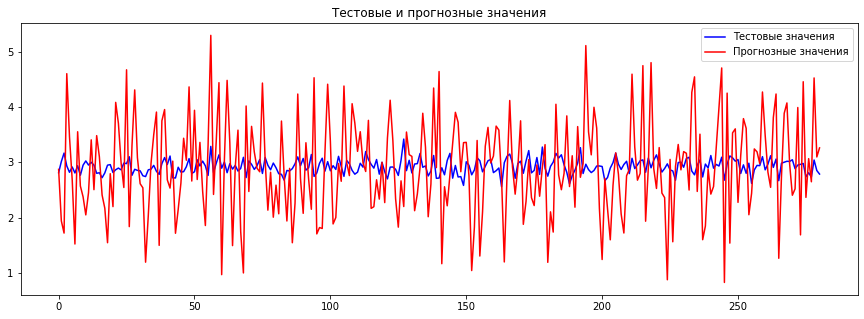

In [22]:
pred = model.predict(np.array((X_test)))
original = y_test
predicted = pred

actual_and_predicted_plot(predicted, original)

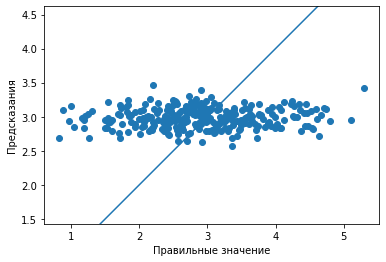

In [26]:
# Разброс предсказаний может показать перекос, если есть
plt.scatter(y_test, pred) 
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

(array([ 4., 13., 34., 52., 61., 59., 41., 13.,  1.,  3.]),
 array([2.5759218, 2.6654704, 2.755019 , 2.8445675, 2.9341161, 3.0236647,
        3.1132133, 3.202762 , 3.2923105, 3.381859 , 3.4714077],
       dtype=float32),
 <BarContainer object of 10 artists>)

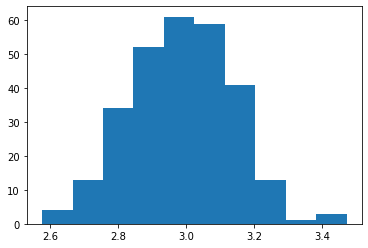

In [27]:
plt.hist(pred)

In [28]:
model.save("divination_mlp_10")

INFO:tensorflow:Assets written to: divination_mlp_10\assets


In [30]:
mod = np.array(X_test)[0]

In [31]:
mod.shape

(11,)